<div align='center'>
    
## Image Processing

### Peas On Desk Practical

#### 10/02/2022, Ver. 1.0 
</div>

### 0. Introduction

Image processing/computer vision has evolved a number of techniques that are quite distinct from classical statistical (multivariate) techniques and machine learning for dealing with the special nature of digital images.  One set of very successful, fast techniques for computer vision is based on _binary_ image processing which we begin to explore in this practical.

You are given an image `croppedpeasondesk.jpg`  which is available off the VLE.  Load this into _Python_ using tools from PIL, and assign the image to variable `X`; display the image.  

Note the image type (i.e. paletted or RGB (full colour)); use `np.shape` or other techniques from previous practicals to understand its shape and representation.  It is important that you understand how the size and type of the image data – and its representation in _Python_, relate to the display of the image.  If you are not sure what this means, ask a demonstrator.

The aim of this exercise is to count and find the locations of the peas using the simplest possible set of operations. From this, even though it will be imperfect, we will create a “database” of pea images. 

Whilst this might seem a rather bizarre thing to do, the apparent simplicity of the exercise introduces you to several topics that are usually hidden, such as the statistical characterisation of image data. The ideas we meet here have extensions to object recognition and to methods that are used to statistically characterise images). **Task 3** also implicitly contains an exercise in image registration, although I don’t describe it as such.

### 1. A simple approach to segmentation

Well, we could really complicate this, and train a deep neural network to recognise peas. But this would not give us insight into some of the value of understanding colour-spaces.  Secondly, the big headache of pure data driven techniques is that we need to provide training data for such an approach. So, instead, we will try to use some heuristics to detect the locations of peas in the image. Though this will never be perfect, it can be used to bootstrap the acquisition of label data that can then be used to train a network.

We are going to first look at the intensity image, just to see what information it contains. We will use the tools of **PIL** and **scikit-image** to provide the basic functionality. If you have not yet done so, please install **scikit-image** using (if you are using `conda`), entered at the command prompt (PowerShell, `bash` or `zsh` prompt with the appropriate `conda` environment selected.  

`conda install scikit-image`

or the graphical package installer if you are using it. The user documentation for **scikit-image** is to found [here](https://scikit-image.org/docs/stable/user_guide.html). There are a number of subpackages that are listed [here](https://scikit-image.org/docs/stable/api/skimage.html#subpackages).

#### 1.1 Getting Started

In [1]:
conda install -c anaconda pillow #make sure its PIL v8 and above

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.



CondaValueError: invalid package specification: #make



In [2]:
import PIL
from PIL import Image
from skimage import color as skco
import numpy as np
import matplotlib.pyplot as plt
PIL.__version__


'9.3.0'

Text(0.5, 1.0, 'Fig. 1. Peas On Desk')

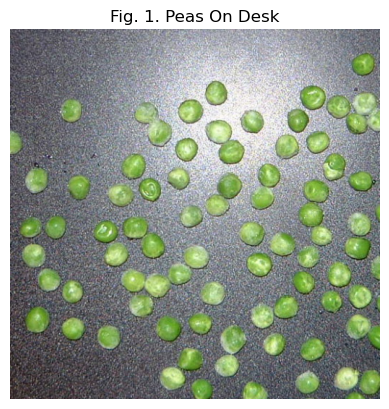

In [3]:
p_image = Image.open('IMGS/croppedpeasondesk.jpg')
plt.imshow(p_image)
plt.axis('off')
plt.title('Fig. 1. Peas On Desk')

Having seen that intensity-based segmentation works nicely for rice grains, let's have a look at the histogram of _achromatic intensity_ first. This is a useful learning experience, showing a _counter example_ of the idea shown in the lectures of using intensity-based segmentation.

Text(0.5, 1.0, 'Fig. 2. Peas on Desk Gray-scale(intensity)')

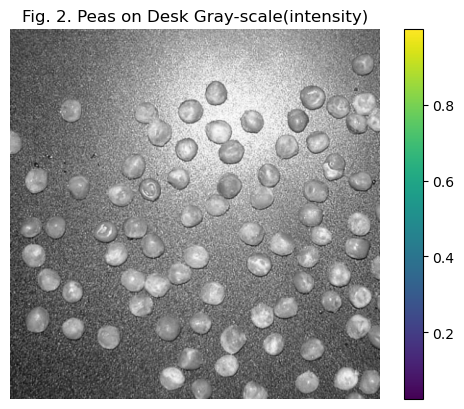

In [4]:
na = np.array(p_image)
gr_im = skco.rgb2gray(na) #convert into a gray-scale
plt.imshow(gr_im, interpolation=None) # no interpolating
plt.axis('off')
plt.colorbar()
plt.title('Fig. 2. Peas on Desk (intensity)')

grey_map=plt.get_cmap('gray')
plt.imshow(gr_im, cmap=grey_map, interpolation=None)
plt.title('Fig. 2. Peas on Desk Gray-scale(intensity)')

<div style="background:#EEEEFF;color:black">
    
**Exercise 1** Using your results from the previous practical, display the image of Fig. 2 with a greyscale colourmap. &#9724;

<div>

<hr><details> <summary> Click <b>here</b> to see the solution to Ex. 1. </summary>

```python
grey_map=plt.get_cmap('gray')
plt.imshow(gr_im, cmap=grey_map, interpolation=None)
```
</details>

You should recognise that you can still see the peas, even with the absence of colour. Despite this, intensity on its own will not be a great cue to use to separate peas from desk: although the peas  _generally_ have lower pixel values than the background desk (which is a textured black), there is a very bright reflection off a substantial portion of the desk, where the peas actually have almost overlapping intensity with the background. 

Looking at and plotting the _histogram_ of the pixel values will allow this to be more easily seen.

#### 1.2 Constructing a histogram of intensities

Although **matplotlib** has its own histogram routines, I recommend using the `numpy` histograms: you have more control over what you are doing, and you are less likely to get silly autoscaling mistakes, whereby two histograms being compared are constructed using different bins.

You can find the documentation for the histogram function [here](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html). But we'll walk you through this to begin with:

In [5]:
# First, let's see what range of values we are dealing with
min_intensity = np.min(gr_im)
max_intensity = np.max(gr_im)
print('Min:', min_intensity, ', Max:', max_intensity)

Min: 0.02382705882352941 , Max: 0.9991666666666668


So, we have floating point intensity values. We can form a histogram by simply relying on autoscaling of histogram, and just specify the number of bins. Since we have so many pixels (how many?), we can use _lots_ of bins. Let's use 100!

[   2    0    1    3   12   13   21   33   44   79  116  139  205  279
  338  433  554  702  801  974 1085 1431 1577 1919 2166 2404 2806 2896
 3332 3610 3898 4108 4350 4357 4650 4781 4834 4945 4874 4907 4967 4959
 4915 5001 5027 4990 4930 4804 4870 4777 5032 4917 4856 4887 4875 4886
 4932 4799 4948 4913 4889 4670 4596 4576 4301 4164 3970 3940 3565 3543
 3218 3077 2812 2789 2597 2487 2336 2225 2099 1953 1902 1777 1742 1634
 1540 1463 1334 1319 1180 1212 1119 1116  973  966  906  746  618  460
  275   91]
0.00975339607843137


Text(0.5, 1.0, 'Fig. 3. Histogram of intensities')

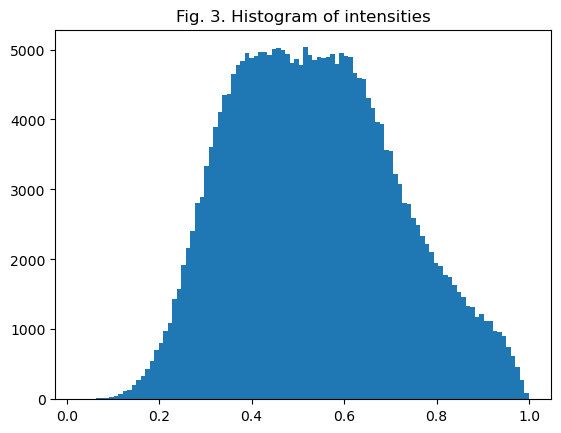

In [6]:
h, bin_edges = np.histogram(gr_im, bins=100)
print(h)

# by default, plt.bar is dumb: all bars have a width 0f 0.8! Phht....
barw = bin_edges[1]-bin_edges[0] # Should be the same for all bins.
print(barw)

plt.bar(bin_edges[:-1], h, width=barw, align='edge') # ...set bar width properly.
plt.title('Fig. 3. Histogram of intensities')

<div class="alert alert-warning">
    
If you try to compute the histogram using `plt.hist()` directly, you may get unpredictable results. I strongly advise not going this route unless you have fully understood the idiosyncracies of automatic scaling. 

</div>

<div class="alert alert-info">
    
What do you think `bin_edges` contains? You should examine the shape of `bin_edges`, and its values to make sure you understand where they come from. One thing to be _very_ careful with is that the upper and lower limits
of the histogram are set automatically _unless_ we explicitly set them. So, my preference would be to use this syntax:

```python
bin_edges = np.linspace(0, 1.0, 101)
h, _ = np.histogram(gr_im, bins=bin_edges)
barw = bin_edges[1]-bin_edges[0] # the default bar width is silly
plt.bar(bin_edges[:-1], h, width=barw, align='edge')     
plt.title('Fig. 3a. Histogram of approximate intensities')
```
You should compare the figure this produces with the first histogram; the differences are minimal, but can be important, depending on the context and data.

</div>




[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
0.01


Text(0.5, 1.0, 'Fig. 3a. Histogram of approximate intensities')

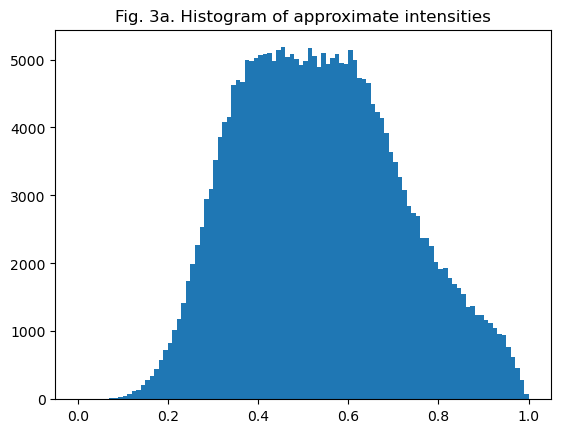

In [6]:
bin_edges = np.linspace(0, 1.0, 101) #Return evenly spaced numbers over a specified interval.
print(bin_edges)
h, _ = np.histogram(gr_im, bins=bin_edges)
barw = bin_edges[1]-bin_edges[0] # the default bar width is silly
print(barw)
plt.bar(bin_edges[:-1], h, width=barw, align='edge')     
plt.title('Fig. 3a. Histogram of approximate intensities')

**Interlude 1** The important thing to observe is that there is **no** obvious place to set a threshold for this histogram to separate the peas from the desk. But we need to repeat this exercise with the colour information in the image to see what we get.

<div style="background:#EEEEFF;color:black">
    
**Exercise 2** Using your experience from Practical 1, and in particular, `getchannel()`, extract the individual R, G, B channels from the peas on desk image; display each of the channels as an image, with an appropriate colourmap, and then compute the histogram of each of the channels. &#9724;

<div> 

<PIL.Image.Image image mode=L size=512x512 at 0x27390E18D00>


Text(0.5, 1.0, 'Histogram of red')

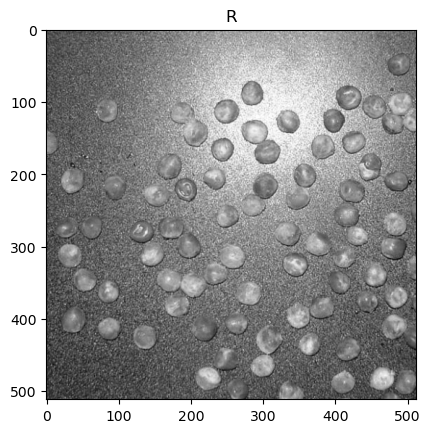

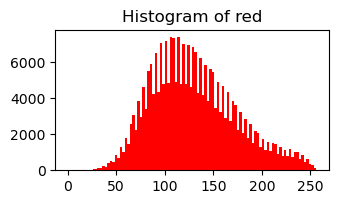

In [7]:
R = p_image.getchannel('R')
G = p_image.getchannel('G')
B = p_image.getchannel('B')

print(R)#image is 512x512

##Display each channel as an image
plt.imshow(R, cmap='gray')
plt.title('R')

#Plot histogram
bin_edges = np.linspace(0, 256, 101)
hr, _ = np.histogram(R, bins=bin_edges)
hg, _ = np.histogram(G, bins=bin_edges)
hb, _ = np.histogram(B, bins=bin_edges)

barw = bin_edges[1]-bin_edges[0] # the default bar width is silly

plt.figure(figsize=(12,4))
plt.subplot(2,3,4)
plt.bar(bin_edges[:-1], hr, width=barw, align='edge', color='r')     
plt.title('Histogram of red')

<hr><details>
<summary> Click <b> here </b> to see one solution to Ex. 2 </summary>

```python

R = p_image.getchannel('R')
G = p_image.getchannel('G')
B = p_image.getchannel('B')

# To display the images, we can do this:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(R, cmap='gray')
plt.title('R')

plt.subplot(1,3,2)
plt.imshow(G, cmap='gray')
plt.title('G')

plt.subplot(1,3,3)
plt.imshow(B, cmap='gray')
plt.title('B')

bin_edges = np.linspace(0, 256, 101)
hr, _ = np.histogram(R, bins=bin_edges)
hg, _ = np.histogram(G, bins=bin_edges)
hb, _ = np.histogram(B, bins=bin_edges)

barw = bin_edges[1]-bin_edges[0] # the default bar width is silly

plt.figure(figsize=(12,4))
plt.subplot(2,3,4)
plt.bar(bin_edges[:-1], hr, width=barw, align='edge', color='r')     
plt.title('Histogram of red')


plt.subplot(2,3,5)
plt.bar(bin_edges[:-1], hg, width=barw, align='edge', color='g')     
plt.title('Histogram of green')


plt.subplot(2,3,6)
plt.bar(bin_edges[:-1], hb, width=barw, align='edge', color='b')     
plt.title('Histogram of blue')

```
    
</details>

Text(0.5, 1.0, 'Histogram of blue')

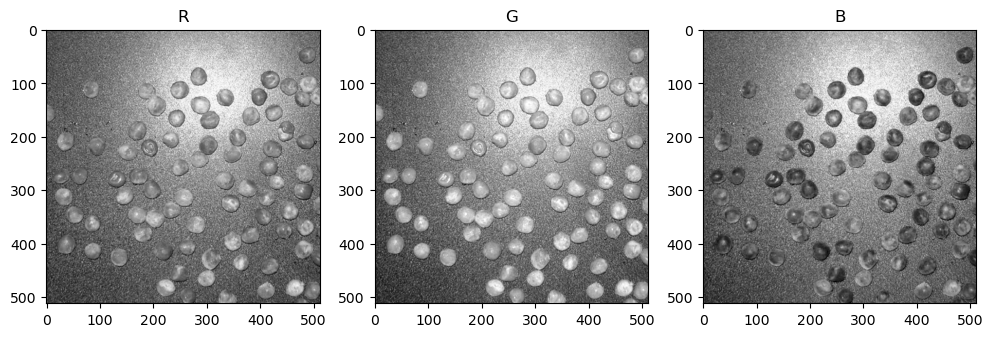

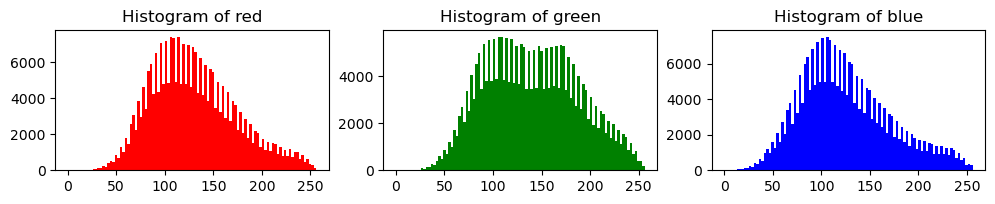

In [8]:
R = p_image.getchannel('R')
G = p_image.getchannel('G')
B = p_image.getchannel('B')

# To display the images, we can do this:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(R, cmap='gray')
plt.title('R')

plt.subplot(1,3,2)
plt.imshow(G, cmap='gray')
plt.title('G')

plt.subplot(1,3,3)
plt.imshow(B, cmap='gray')
plt.title('B')

bin_edges = np.linspace(0, 256, 101)
hr, _ = np.histogram(R, bins=bin_edges)
hg, _ = np.histogram(G, bins=bin_edges)
hb, _ = np.histogram(B, bins=bin_edges)

barw = bin_edges[1]-bin_edges[0] # the default bar width is silly

plt.figure(figsize=(12,4))
plt.subplot(2,3,4)
plt.bar(bin_edges[:-1], hr, width=barw, align='edge', color='r')     
plt.title('Histogram of red')


plt.subplot(2,3,5)
plt.bar(bin_edges[:-1], hg, width=barw, align='edge', color='g')     
plt.title('Histogram of green')


plt.subplot(2,3,6)
plt.bar(bin_edges[:-1], hb, width=barw, align='edge', color='b')     
plt.title('Histogram of blue')



**Quiz** Do you think it would be possible to set a threshold on the green channel of the Peas on Desk image, in order to obtain binary regions that correspond to peas?  Try it! What do you observe, and what is the explanation?

<PIL.Image.Image image mode=L size=512x512 at 0x1CFE0942D00>


Text(0.5, 1.0, 'G_simple_thresholding')

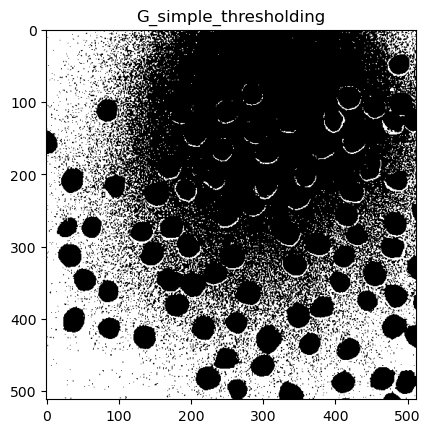

In [10]:
#extract green channel
G = p_image.getchannel('G')
print(G)
plt.imshow(G, cmap='gray')
plt.title('G')

#threshold
threshold= 120 #select a value here
G = np.asarray(p_image.getchannel('G'))
G = np.where(G < threshold, 255, 0)

plt.imshow(G, cmap='gray')
plt.title('G_simple_thresholding')


<hr><details>
<summary outline="1pt">🆘<b>Click here if stuck on the quiz.</b></summary>
The answer is no: the best threshold that you could set (from the lectures, where might it be?) is going to leave you with either lots of missed peas, or a massive chunk of the region of the image containing the large specular reflection.
</details>

<div style="background:#EEEEFF;color:black">
    
**Exercise 3** Using your experience from **Practical 1**, and in particular, the normalised or trichromatic coefficients, calculate and display the spatial fields corresponding to _nR_, _nG_ and _nB_.  

_Hint_: You need to be **careful** with numeric representations in doing these calculations. But remember that `numpy` has routines specifically for converting from one numeric representation to another. &#9724;

<div> 

<hr><details> <summary> Click <b>here</b> for one solution to Ex. 3 </summary>
    
```python

# Start by converting everything to floating point
fR = np.asarray(R, dtype=float)
fG = np.asarray(G, dtype=float)
fB = np.asarray(B, dtype=float)

# Check the shape as you do these calculations
my_eps = 0.001 # Avoids divide by zero!
denominator = (fR+fG+fB+my_eps)

nR = fR/denominator
nG = fG/denominator
nB = fB/denominator

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('nR')
plt.imshow(nR, cmap=grey_map)
plt.subplot(1,3,2)
plt.title('nG')
plt.imshow(nG, cmap=grey_map)
plt.subplot(1,3,3)
plt.imshow(nB, cmap=grey_map)
plt.title('nB')
    
```
</details>

(512, 512)


Text(0.5, 1.0, 'nB')

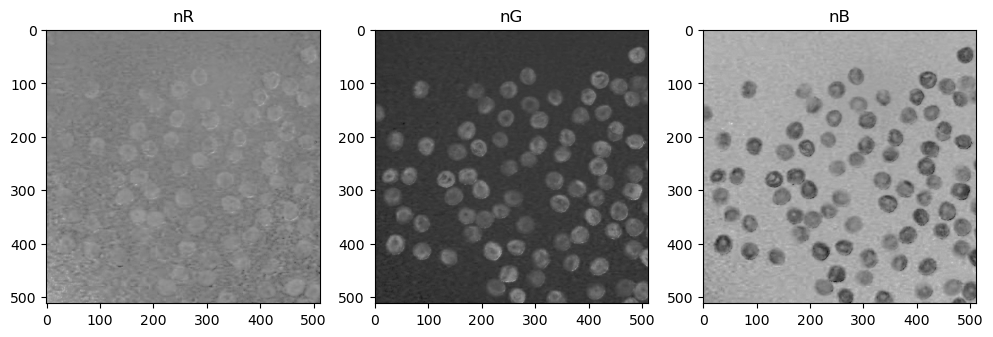

In [9]:
# Start by converting everything to floating point
fR = np.asarray(R, dtype=float)
fG = np.asarray(G, dtype=float)
fB = np.asarray(B, dtype=float)

# Check the shape as you do these calculations
my_eps = 0.001 # Avoids divide by zero!
denominator = (fR+fG+fB+my_eps)

nR = fR/denominator
print(nR.shape)
nG = fG/denominator
nB = fB/denominator

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('nR')
plt.imshow(nR, cmap=grey_map)
plt.subplot(1,3,2)
plt.title('nG')
plt.imshow(nG, cmap=grey_map)
plt.subplot(1,3,3)
plt.imshow(nB, cmap=grey_map)
plt.title('nB')


<div style="background:#EEEEFF;color:black">
    
**Exercise 4** Calculate and display the histograms corresponding to _nR_, _nG_ and _nB_. What do you notice about the histograms of these channels? Which ones can be used to separate the peas from the background? &#9724;

<div> 

Text(0.5, 1.0, 'Histogram of nB')

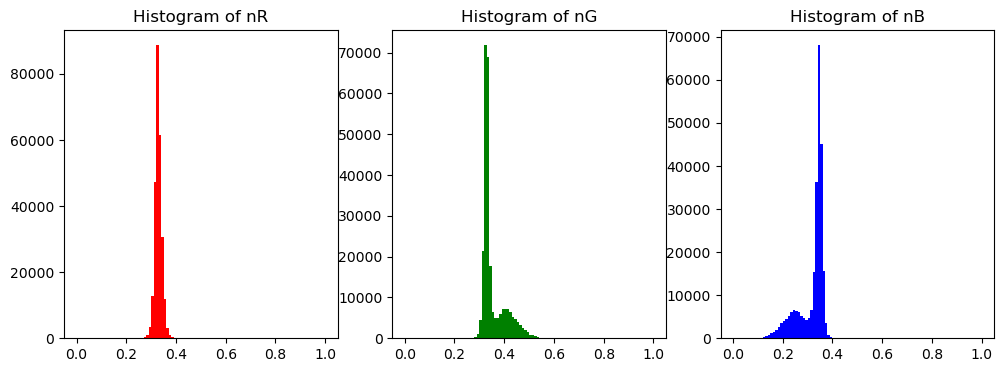

In [10]:
# Assuming that Ex. 3 has been completed!
bin_edges = np.linspace(0, 1, 101) # Why? And can we do better?
hnR, _ = np.histogram(nR, bins=bin_edges)
hnG, _ = np.histogram(nG, bins=bin_edges)
hnB, _ = np.histogram(nB, bins=bin_edges)

barw = bin_edges[1]-bin_edges[0] # the default bar width is silly

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.bar(bin_edges[:-1], hnR, width=barw, align='edge', color='r')     
plt.title('Histogram of nR')


plt.subplot(1,3,2)
plt.bar(bin_edges[:-1], hnG, width=barw, align='edge', color='g')     
plt.title('Histogram of nG')


plt.subplot(1,3,3)
plt.bar(bin_edges[:-1], hnB, width=barw, align='edge', color='b')     
plt.title('Histogram of nB')


#Here is where the cool stuff happens.
#Normalizing each color helps to group background from peas in the image.

<hr><details>
<summary> Click <b> here </b> to see one solution to Ex. 4 </summary>

```python
# Assuming that Ex. 3 has been completed!
bin_edges = np.linspace(0, 1, 101) # Why? And can we do better?
hnR, _ = np.histogram(nR, bins=bin_edges)
hnG, _ = np.histogram(nG, bins=bin_edges)
hnB, _ = np.histogram(nB, bins=bin_edges)

barw = bin_edges[1]-bin_edges[0] # the default bar width is silly

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.bar(bin_edges[:-1], hnR, width=barw, align='edge', color='r')     
plt.title('Histogram of nR')


plt.subplot(1,3,2)
plt.bar(bin_edges[:-1], hnG, width=barw, align='edge', color='g')     
plt.title('Histogram of nG')


plt.subplot(1,3,3)
plt.bar(bin_edges[:-1], hnB, width=barw, align='edge', color='b')     
plt.title('Histogram of nB')

```
</details>

### 2. Creating a Binary Image

The next step in our simple pea analysis exercise is to create a binary image where each pixel is labelled according to whether it belongs to a pea, or the background.

#### 2.1 Examining and Selecting a Threshold

As we have discussed in the practicals, one of the most appropriate ways of doing this is to start by _looking_ at the histogram. You can always automate later if you really need to: there is no substitute for examining the data!

<div style="background:#EEEEFF;color:black">
    
**Exercise 5** Using the material of the lectures, and by carefully examining the histograms you produced in Exercise 4, create a binary image that contains pixels of value 1 if the pixel belongs to a pea, and a value of 0 if the pixel belongs to the background. Call this image-type variable `P_Mask`.

It turns out that more than one channel contains useful information. Which channel do you think is best to use?
</div>

<hr><details>
    <summary> Click <b>here</b> to see one solution to <b>Ex. 5</b>.</summary>
    
Assuming that you have `nG` correctly computed as the normalised
green channel, then
    
`P_Mask = nG > 0.37`
    
will do the trick! This will not be a perfect segmentation
result, but it gets us started. To see the result, just (then) use:
`plt.imshow(P_Mask)`
    
</details>

In [11]:
#input data is nR,nG,nB
nR.shape

(512, 512)

Text(0.5, 1.0, 'P_Mask')

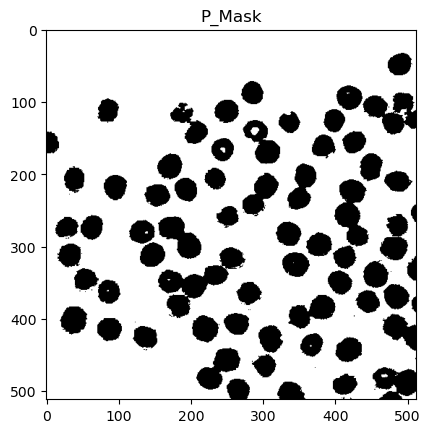

In [12]:
#threshold
threshold= 0.37 #select a value here
P_Mask= np.where(nG < threshold, 255 ,0)


plt.imshow(P_Mask, cmap='gray')
plt.title('P_Mask')

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


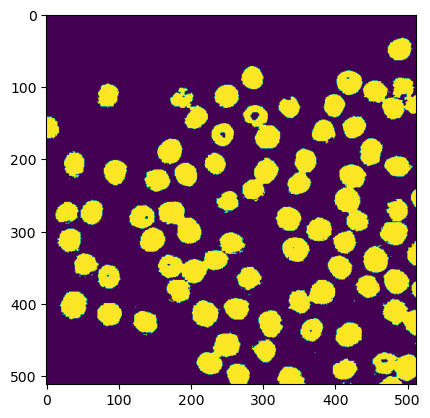

In [13]:
P_Mask = nG > 0.37 # if nG >threshold set to True
print(P_Mask)
plt.imshow(P_Mask) #plots an array of True and False 

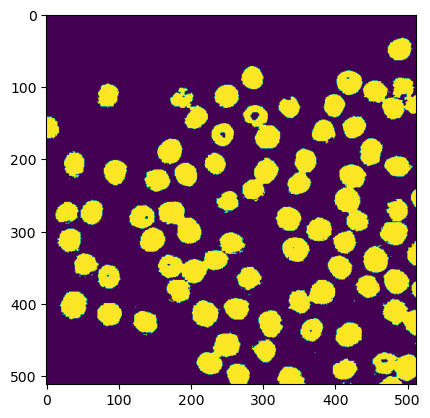

In [13]:
#Picture should be similar to this one which Prof has saved
P_Mask=np.load('IMGS/MaskFromNGreen.npy')
plt.imshow(P_Mask) #plots an array of True and False 

**If you are stuck** having not completed **Ex. 4**, please speak to a demonstrator. To help you progress whilst/if you are waiting for help on Ex. 3 or Ex. 4 there is a saved binary image stored which is loaded by executing the cell below:

In [48]:
# If stuck, you can load a pre-computed pea mask image by running this cell
if 'P_Mask' not in globals().keys():
    P_Mask=np.load('IMGS/MaskFromNGreen.npy')

**Interlude** I have previously griped about the buggy
nature of `imshow()`. Here is a demonstration of that bugginess.

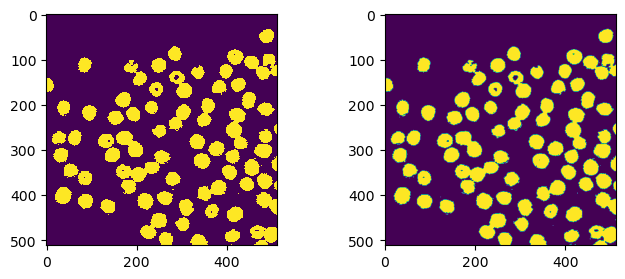

In [15]:
%matplotlib inline
    
# Demonstration of broken imshow() (at least on my machine)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(255*P_Mask, interpolation='none')
plt.subplot(1,2,2)
plt.imshow(255*P_Mask, interpolation=None)

**Explanation of the problem that I see on _my_ installations**: 
the image on the lect has only two visible colours, blue and yellow; the one on the right has a green border around all the peas, if I use the default colourmap. This is because `imshow` is interpolating the image, despite trying to turn it off with the `None` keyword. It does turn it off if I use "none" as a string.... You may see something entirely different.

#### 2.2 Labelling each pea ####

Assuming we have a binary image mask assigned, we can apply _connected components labelling_ to the task of labelling each region. We **will** have some erroneous regions, but the point is that we can use properties of each region (including moments etc) to reject regions that are unlikely to be single peas.

Text(0.5, 1.0, 'Connected Components Labelling')

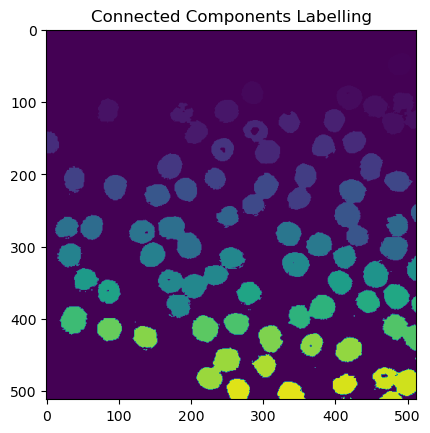

In [14]:
from matplotlib import colors
from skimage.measure import label, regionprops

P_L = label(P_Mask)
plt.imshow(P_L)
plt.title('Connected Components Labelling')

Text(0.5, 1.0, 'Another visualisation of labels')

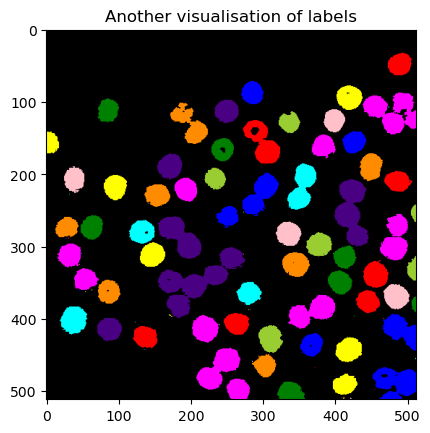

In [17]:
# Funkier option
plt.imshow(skco.label2rgb(P_L, bg_label=0))
plt.title('Another visualisation of labels')

#### 2.2 Region Properties ####

The **scikit-image** library contains a set of _modules_ for
analysing binary image regions. We will look at one big fat function called `regionprops()`.

In [15]:
from skimage.measure import regionprops

Regions = regionprops(P_L)

# Examine the type of the return
print(type(Regions))

<class 'list'>


So, let's look at the length of the list, and also grab one item from this list and probe it:

In [18]:
print(len(Regions))

99


And let's also look at **one** of the items from the list and see what it contains:

In [19]:
print(type(Regions[0]))

<class 'skimage.measure._regionprops.RegionProperties'>


So, this is an object. Let's see what it contains:

In [20]:
dir(Regions[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_cache_active',
 '_extra_properties',
 '_image_intensity_double',
 '_intensity_image',
 '_label_image',
 '_multichannel',
 '_ndim',
 '_slice',
 '_spatial_axes',
 'area',
 'area_bbox',
 'area_convex',
 'area_filled',
 'axis_major_length',
 'axis_minor_length',
 'bbox',
 'centroid',
 'centroid_local',
 'centroid_weighted',
 'centroid_weighted_local',
 'coords',
 'eccentricity',
 'equivalent_diameter_area',
 'euler_number',
 'extent',
 'feret_diameter_max',
 'image',
 'image_convex',
 'image_filled',
 'image_intensity',
 'inertia_tensor',
 'inertia_tensor_eigvals',
 'i

Ooh! Lots of either methods (object-specific functions) or attributes; let's look further at the first of these intended for us to play with (those with `__xxxx__` are usually internal variables/attributes of the object):

In [21]:
print(dir(Regions[0].area))

['T', '__abs__', '__add__', '__and__', '__array__', '__array_interface__', '__array_priority__', '__array_struct__', '__array_wrap__', '__bool__', '__class__', '__class_getitem__', '__copy__', '__deepcopy__', '__delattr__', '__dir__', '__divmod__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__le__', '__lshift__', '__lt__', '__mod__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdivmod__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rlshift__', '__rmod__', '__rmul__', '__ror__', '__round__', '__rpow__', '__rrshift__', '__rshift__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__xor__', 'all', 'any', 'argmax', 'argmin', 'argsort', 'astype', 'base', 'bit_count

So this looks like a variable that is a number or array. Let's see what it has:

In [22]:
print(Regions[0].area)

803


So, this is just a number. Looking at the documentation of **scikit-image** (named, rather stupidly, `skimage` as a module), we can see that this should tell us the number of pixels in the region. Let's look at another property of the same region:

In [23]:
print(Regions[0].bbox)

(33, 473, 64, 507)


So, these are $(m,n)$ coordinates that correspond to an enclosing box in the coordinate space of the image: the box encloses the pixels of the particular region we are considering. Be careful, as -- generally speaking -- they might be in either an $(x,y)$ coordinate system or an $(m,n)$ coordinate system, in which case we may have to swap coordinates around when plotting or when trying to relate a position in a classical $(x,y)$ coordinate system to a position in the image array!

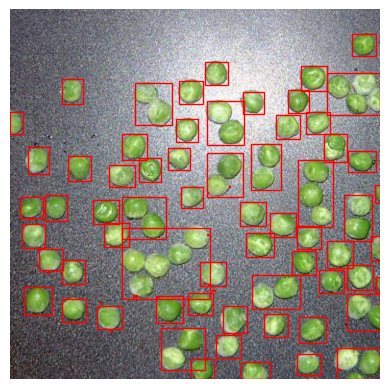

In [24]:
# We get hold of a rectangle drawing routine...
from matplotlib.patches import Rectangle as drawrect

# Let's collect all the bounding box information to try 
# to visualise it; below, we are using List Comprehension
BBs = [thisRegion.bbox for thisRegion in Regions]

# And let's try to plot it; to do this, we will need to 
# make sure that the command used to do plotting of the 
# lines representing the boxes that bound each
# region is consistent with the coordinate system of
# the image. In a concrete sense, we want to use the 
# same AXIS for plotting both. Hence, our plotting needs
# to be a bit more sophisticated than we have done before...

# Create a figure and return an axis object
fig, ax = plt.subplots() # no argument to subplots means just 1

ax.imshow(p_image) # rather than plt.imhsow(), we explicitly 
                   # draw it on the axis of the figure window
ax.axis('off')   

for bb in BBs:    
    r = drawrect((float(bb[1]),float(bb[0])),
                 bb[3]-bb[1],bb[2]-bb[0], 
                 edgecolor='r', facecolor='none')
    ax.add_patch(r)

Well, that looks like it worked, but as we can see, there are some regions that actually contain multiple peas.  You can see the problem if you have a look at the original connected components results, where there are as many as 5 peas that, when labelled, are treated as one cluster (region). We will learn how to deal with this in Chapter 4. But for now, our main goal is to identify the boxes corresponding to valid _single pea_ regions. How can we do this?

#### 2.3 Filtering Regions

All pattern recognition algorithms will, at some point, fail. So, it is important to be able to use simple heuristics to identify implausible results in the simplest way possible.

Looking at properties of binary regions is one of the things that we can do to easily improve results, rejecting regions that do not fit the criteria that we expect.

First, let's look at a simple heuristic based on the sizes of regions found by our thresholding and connected components labelling. We will start by collecting and forming a histogram of the region areas (i.e. number of pixels in each region) that have been detected.

[803, 753, 931, 2499, 734, 839, 1333, 2, 721, 627, 1610, 762, 450, 763, 735, 924, 918, 1548, 758, 654, 792, 1559, 857, 797, 1, 2602, 835, 1, 1, 122, 1, 632, 1, 1665, 805, 1902, 688, 879, 905, 897, 3, 2, 908, 818, 749, 4076, 988, 1, 1, 295, 986, 1, 1, 747, 831, 1, 794, 778, 936, 2, 770, 2, 1, 1720, 100, 1, 1, 1083, 1, 1, 818, 1343, 6, 1034, 2, 858, 1, 1, 2, 946, 799, 751, 963, 1843, 2, 3, 707, 2, 2, 1, 1, 1877, 729, 741, 720, 2, 5, 1, 3]


Text(0, 0.5, 'Number of regions with this size')

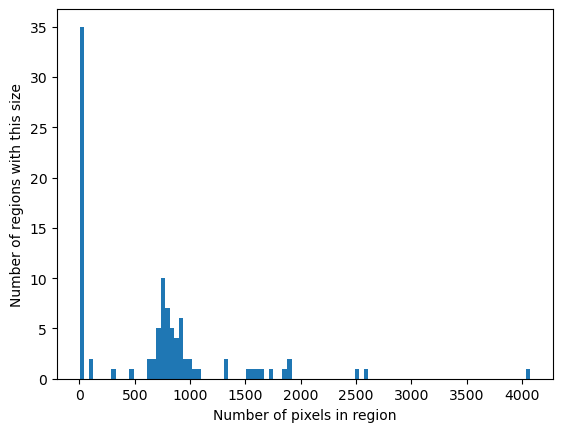

In [25]:
Areas = [thisRegion.area for thisRegion in Regions]
print(Areas)

# I am taking the lazy option here! Compare with
# previous use of np.hist. 
HistogramOfPeaSize = plt.hist(Areas, 100) 
plt.xlabel('Number of pixels in region')
plt.ylabel('Number of regions with this size')

<div style="background:#EEEEFF;color:black">
    
**Exercise 6** Interpret the reason for the appearance of the histogram, paying particular attention to the locations of peaks. Can you determine an appropriate criterion to apply to the regions to remove those that are unlikely to correspond to single whole peas?
    
_Hint_ After filtering, your bounding boxes should look something like that shown below, and you will have somewhere between 50 and 65 regions:
<hr>   </hr>

![Example of filtered pea regions](IMGS/FilteredRegions.png)
    
Hint Figure (above): Shows the bounding boxes **after** a simple region filtering.
<hr>   </hr>
</div>

<hr><details><summary> Click <b> here </b> for one solution to Ex. 6.</summary>
    
```python
# One Solution, using list comprehension
ValidRegions = [region for region in RegionProperties if 
                         (region.area>50 and region.area<1200)]

```
</details>

In [26]:
#Filter regions that are too small or too large since they are unlikely to hold 1 pea

RegionProperties=Regions
# One Solution, using list comprehension
ValidRegionProperties = [region for region in Regions if 
                         (region.area>50 and region.area<1200)]
print(ValidRegionsProperties)

NameError: name 'ValidRegionsProperties' is not defined

In [32]:
#Another solution
#ValidRegionProperties=[]
#for area in Areas:
#    if area <1200:
#        if area >50:
#        ValidRegionProperties.append(area)
#        
#print(ValidRegionsProperties)

[803, 753, 931, 734, 839, 2, 721, 627, 762, 450, 763, 735, 924, 918, 758, 654, 792, 857, 797, 1, 835, 1, 1, 122, 1, 632, 1, 805, 688, 879, 905, 897, 3, 2, 908, 818, 749, 988, 1, 1, 295, 986, 1, 1, 747, 831, 1, 794, 778, 936, 2, 770, 2, 1, 100, 1, 1, 1083, 1, 1, 818, 6, 1034, 2, 858, 1, 1, 2, 946, 799, 751, 963, 2, 3, 707, 2, 2, 1, 1, 729, 741, 720, 2, 5, 1, 3]


<div style="background:#EEEEFF;color:black">
    
**Exercise 7** Using the `centroid` attribute of the bounding boxes, plot the centroid as a small circle on each pea region using the **matplotlib** `scatter` method. Adjust the plotting using the size of the marker until you get the plot looking about right. 
    
_Hint_ Your result should look something like that shown in the figure below.  
![Example of filtered pea regions](IMGS/CentroidRegions.png)
</div>

<hr><details><summary> Click <b>here</b> for one solution to <b>Ex 7.</b></summary>
    
```python

Areas = [thisRegion.area for thisRegion in ValidRegionProperties]
BBs = [thisRegion.bbox for thisRegion in ValidRegionProperties]
Centroids = [thisRegion.centroid for 
            thisRegion in ValidRegionProperties]
    
fig, ax = plt.subplots()
ax.imshow(p_image)
ax.axis('off')

# The zip thing is not needed, you can instead use
# enumerate and grab the corresponding indexed
# value from each list, but this is more readable...
for (bb,area,centroid) in zip(BBs,Areas,Centroids):
    r = drawrect((float(bb[1]-1),float(bb[0]-1)),
        bb[3]-bb[1],bb[2]-bb[0], 
        edgecolor='r', facecolor='none')
    
    ax.add_patch(r)
    plt.scatter(centroid[1]-1, centroid[0]-1, c='r', s=2)

```
</details>

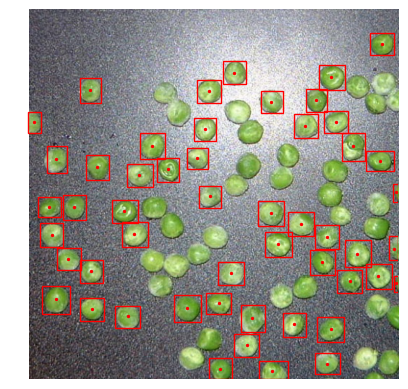

In [27]:
Areas = [thisRegion.area for thisRegion in ValidRegionProperties]
BBs = [thisRegion.bbox for thisRegion in ValidRegionProperties]
Centroids = [thisRegion.centroid for 
            thisRegion in ValidRegionProperties]

fig, ax = plt.subplots()
ax.imshow(p_image)
ax.axis('off')

# The zip thing is not needed, you can instead use
# enumerate and grab the corresponding indexed
# value from each list, but this is more readable...
for (bb,area,centroid) in zip(BBs,Areas,Centroids):
    r = drawrect((float(bb[1]-1),float(bb[0]-1)),
        bb[3]-bb[1],bb[2]-bb[0], 
        edgecolor='r', facecolor='none')

    ax.add_patch(r)
    plt.scatter(centroid[1]-1, centroid[0]-1, c='r', s=2)

### 3. Creating an Ensemble of Peas!

In order to make explicit the concept of what an “average” pea is, we will stack individual peas into an experimental space.  However, before we do this, there are some things to take into consideration. These details do not alter the concept of averaging across experimental (or observation) space, but they are nevertheless important, because they involve practical issues.  These issues will be present in whatever programming language you use, so this has not much to do with _Python_, specifically.

#### 3.1 2D, 3D and 4D arrays
We can view a 2D array as consisting of a set of 1D arrays which are stacked together, row by row, or column by column.  In the same way, we can view a 3D array as a series of 2D arrays which are stacked one after the other into the third dimension.  

However, in all cases (i.e. 1D->2D or 2D->3D) each d-dimensional array being constructed by stacking (d-1) dimensional arrays should be of the same size. What we have seen so far is that the bounding boxes around each pea are of different sizes. 

So, how do we arrange these peas into a third dimension (experimental space in our case, or pea-space if you are so inclined). If we go back to the colour pea image, we’d actually be placing each three-dimensional patch into one “hyperslice” in the 4th dimension, which will be the experimental space.

#### 3.2 A recipe for how to stack the peas into a 4D array
NB: You may try to do this yourself, with no hints.  But before you start, I suggest thinking about the problem carefully, sketching, as best you can, what is involved in this exercise.

 - First, eliminate all regions that are not likely to be peas, because of their size.  In order to construct the 4 dimensional array of peas (we have width, height, colour channels and then pea "instance"), we need to place all the pea regions into one array, preferably so that all their centres are aligned. Since the bounding boxes around the peas will be of different sizes, we need a bit of work to place all pea regions into a four-dimensional array by making sure each pea patch is of the same size.  

 - Why is this necessary? From a programming point of view, all rows of a digital image have the same number of columns, and all slices of a 3D matrix should be of the same number of elements. Thus, one solution is to take the largest practical patch size that contains all peas which can then be used as the “common” dimensions for all images in the pea array.  

 - Find the **largest bounding** box amongst the peas that you have detected.  The aim here is to find a common size that can be used to generate the four dimensional pea array.  This should not be too large compared to the size of most peas, so be careful in estimating this.  Once you have a rough idea of what size the common bounding box size around each centroid should be, you would then extract, from the original image, the pixels within the bounding box, and stack them into a 4D array. **Convey this to a demonstrator**.

 - In stacking the peas into a 4D array, we want to do this so that all of the pea centres are aligned in (_row_,_column_) space, or aligned with the centre of each “slice” of the 4D array as closely as possible. The most convenient way to do this and to first write a function (```def getsquareregion()```), that takes in the whole image, and extracts the region that you specify through passing in the centroid and width/length of the square box size as arguments. Making it a square is sensible, as there is no particular reason (in this data) that there should be any isotropy in the average pea. If the extracted region might fall partly outside the image, reject the region (return nothing, or `None`). Do this in **Exercise 8**.



<div style="background:#EEEEFF;color:black">
    
**Exercise 8**  Create a _Python_ function to extract a square region from an input image. The inputs should be the image, the centroid of the desired region and its width/height. You should return a `numpy array`. &#9724;

<div>

<hr><details><summary> Click <b>here</b> for one solution to Ex. 8 </summary>
    
```python
def getsquaregionfromimage(image, centroid, LW):
    
    # This should work, if it does not speak to a demonstrator
    image = np.asarray(p_image)
    
    # Get number of rows/columns and channels
    ImageSize = np.shape(image)
    
    NRows = ImageSize[0]
    NCols = ImageSize[1]
    if len(ImageSize)>2: 
        NChannels = ImageSize[2]
    else:
        NChannels = 1
    
    HalfLW = float(LW)/2.0

    # Upper left coordinate
    UL = (round(centroid[0] - HalfLW), round(centroid[1] - HalfLW))
    LR = (round(centroid[0] + HalfLW), round(centroid[1] + HalfLW))
    
    # Avoid returning an array if the coordinates would take us outside
    # the image array

    if UL[0] < 0 or UL[1] < 0 or LR[0] > NRows or LR[1] > NCols:
        # region = np.asarray([], dtype=image.dtype)
        return None
    else:
        if NChannels==1:
            region = image[UL[0]:LR[0],UL[1]:LR[1]]
        else:
            # The "ellipses" argument in nparray slices a variable number of dims
            region = image[UL[0]:LR[0],UL[1]:LR[1],...]
        
    return region
```    

</details>

In [28]:
def getsquaregionfromimage(image, centroid, LW):

    # This should work, if it does not speak to a demonstrator
    image = np.asarray(p_image)

    # Get number of rows/columns and channels
    ImageSize = np.shape(image)

    NRows = ImageSize[0]
    NCols = ImageSize[1]
    if len(ImageSize)>2: # if we get multiple channels
        NChannels = ImageSize[2]
    else:
        NChannels = 1

    HalfLW = float(LW)/2.0

    # Upper left coordinate
    UL = (round(centroid[0] - HalfLW), round(centroid[1] - HalfLW)) #centroid is the (x,y)
    LR = (round(centroid[0] + HalfLW), round(centroid[1] + HalfLW))

    # Avoid returning an array if the coordinates would take us outside
    # the image array

    if UL[0] < 0 or UL[1] < 0 or LR[0] > NRows or LR[1] > NCols:
        # region = np.asarray([], dtype=image.dtype)
        return None
    else:
        if NChannels==1:
            region = image[UL[0]:LR[0],UL[1]:LR[1]]
        else:
            # The "ellipses" argument in nparray slices a variable number of dims
            region = image[UL[0]:LR[0],UL[1]:LR[1],...]

    return region #holds the pixels of the regions that we identified as peas

<div style="background:#EEEEFF;color:black">
    
**Exercise 9** Create your 4-dimensional stack of single peas! Make sure you eliminate any empty regions before making the stack. Use `subplot()`
(from `matplotlib.pyplot`) with appropriate argument to loop over and display each pea region.  &#9724;

<div>

<hr><details> <summary> Click <b> here </b> for some solutions to Ex. 9. </summary>
    
**Solution 1** Definitely non-Pythonic, and rather inelegant.
    
```python
counter = 0
for C in Centroids:
    arr=getsquaregionfromimage(p_image, C, 41)
    # We only try to stack the results if 
    if not (arr is None):
        counter += 1
        if counter==1: # We place our first pea into the empty stack
            PeaStack=arr
        elif counter==2: # We already have one pea in, but we want to add another
            PeaStack = np.append(PeaStack[:,:,:,np.newaxis], arr[:,:,:,np.newaxis], axis=3)
        else: # PeaStack is already 4 dimensional; just append new 4D data
            PeaStack = np.append(PeaStack, arr[:,:,:,np.newaxis], axis=3)
            
np.shape(PeaStack)

```
<hr>                                   </hr>   

**Solution 2** Quite _Pythonic_ 

```python
    
# Collect all regions
RegionsAsList = [getsquaregionfromimage(p_image, C, 41) for C in Centroids]
#Eliminate empty regions (which were too close to border)
PeaRegionsAsList = [Region for Region in RegionsAsList if not (Region is None)]
PeaStack = np.concatenate([arr[...,np.newaxis] for arr in PeaRegionsAsList], axis=3)

np.shape(PeaStack)
    
```
<hr>                                   </hr>

**Solution 3** Pointlessly _Pythonic_ ...
 
```python
PeaRegionsAsList = [Region for Region 
                   in [getsquaregionfromimage(p_image, C, 41) for C 
                       in Centroids] if not (Region is None)]
PeaStack = np.concatenate([P[...,np.newaxis] for P in PeaRegionsAsList], axis=3)
    
np.shape(PeaStack)

    
```

---

</details>

And if you have run any of the possible `PeaStack` solutions, then following (hidden) code displays a montage of peas: 

<Figure size 640x480 with 0 Axes>

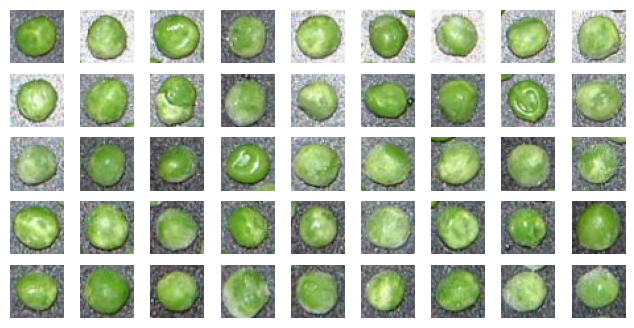

In [29]:
# If stuck, you can load a pre-computed pea mask image by running this cell
if 'PeaStack' not in globals().keys():
    PeaStack=np.load('IMGS/PeaStack.npy')

DisplayCols=9
DisplayRows=5

fig = plt.figure()

_,axs = plt.subplots(DisplayRows,DisplayCols,figsize=(8,4))
slice_no = 0
for r in range(DisplayRows):
    for c in range(DisplayCols):
        axs[r,c].imshow(np.squeeze(np.asarray(PeaStack[...,slice_no],dtype=int)))
        axs[r,c].axis('off')
        slice_no += 1

Finally, we can compute the _average_ pea; you can see this as being the **expected** pea as well, where the observation space is constructed over a single image, but averaging over what we might call pea _instances_:

Text(0.5, 1.0, 'Yum - into the pot with you....!')

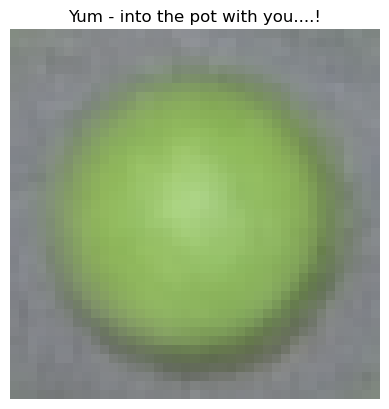

In [30]:
mPea = np.mean(PeaStack, axis=3)
plt.imshow(np.asarray(np.round(mPea), dtype=int))
plt.axis('off')
plt.title('Yum - into the pot with you....!')

### 4.0 Learning Outcomes

It is important not to get lost in, or worry about, the _Python_ syntax of this exercise. From the persecptive of learning outcomes, these are the points that you should be taking home.

1. (Major) In the same way that we discussed the setting of a threshold on intensities in the lectures, you can also set thresholds on channels of colour space to create a simple binary image. In fact, any property at all, calculated at each pixel, can be used for this purpose to label pixels according to whether they belong to one type of structure or another.

2. (Minor) It is nice to have histograms all packaged up for you into routines that you can apply to your own data. But beware of the bins that are used.  Many histogram routines/libraries will set the bins according to the minimum and maximum values in the sample data that is input to compute the histograms. The number of bins can also make a difference. There usually should be a way to override this, and that can be a good idea, particularly if you want to compare the histograms of two different samples of data. If the bins are not in the same place for both samples, comparison can be difficult, and can lead to incorrect conclusions about how similar two distributions are. 

3. (Minor) The spikiness of the histograms is not really noise, but more a consquence of the bin locations of the histogram when the data are quantised (in this case, to integer values).

4. (Major) An alternative colour space (in this case, normalised green and/or normalised blue) can yield separation of pixels that is more in agreement with a human's perception of colour difference than the "raw" RGB colour channels. This can be seen through the ability to find a threshold that separates, reasonably well, the pea pixels from those of the background. Other colour spaces might be similarly effective, but nR,nG,nB is easy to understand/calculate yourself.

5. (Major) Connected components labelling gives you the ability to address individual objects in a binary image.

6. (Minor) Plotting overlays on top of images -- handy to check results of calculations.

7. (Major) You can use properties of binary regions to go back into the image and pull out examples (with full colour) of those regions. Simple region rejection criteria can be used to get objects that are more likely to correspond to the ones you are really interested in.

8. (Major) Creation of a stack of examples, representing "instances" of an object is a comon operation, and particularly so in data-driven approaches to image processing. Acquiring the stack requires some idea of how to align the reference examples. Here, we use centroids, but for other objects, we might use something else. For example, for human faces, the tip of the nose is a common reference point! We can study the stack to calculate the average object or structure (done), and also to quantify variations from the average appearance (beyond the scope of this lab, but for example, PCA/KL can be used to find eigenmodes of variation).

9. (Minor) Some 3D/4D array handling examples, and associated syntax.